In [15]:
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer

In [16]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

model.eval()

print(f"Model name{model_name}")
print(f"Number of layers{model.config.num_hidden_layers}")
print(f"Hidden Size{model.config.hidden_size}")


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model namebert-base-uncased
Number of layers12
Hidden Size768


In [17]:
def get_hidden_states(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)

    hidden_states = outputs.hidden_states

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    return {
        "tokens": tokens,
        "hidden_states": hidden_states,
        "last_hidden_state": outputs.last_hidden_state,
        "pooler_output": outputs.pooler_output
        if hasattr(outputs, "pooler_output")
        else None,
        "attention_mask": inputs["attention_mask"],
    }


In [18]:
text = "Transformers are amazing for NLP task"
result = get_hidden_states(text, model, tokenizer)


print(f"text : {text}")
print(f"tokens: {result['tokens']}")
print(f"Hidden_states layers: {len(result['hidden_states'])}")
print(f"Hidden states size: {result['hidden_states'][0].shape}")
print(f"Last hidden state: {result['last_hidden_state'].shape}")

text : Transformers are amazing for NLP task
tokens: ['[CLS]', 'transformers', 'are', 'amazing', 'for', 'nl', '##p', 'task', '[SEP]']
Hidden_states layers: 13
Hidden states size: torch.Size([1, 9, 768])
Last hidden state: torch.Size([1, 9, 768])


In [ ]:
def visualize_tokens_pca(hidden_states, tokens, layers_to_show=None):
    """
    Pca tokens visualization.
    Shows, how tokens map changes from layer to layer.
    """
    if layers_to_show is None:
        layers_to_show = [0, 4, 8, 12]

    fig, axes = plt.subplots(
        1, len(layers_to_show), figsize=(5 * len(layers_to_show), 5)
    )

    for i, layer_idx in enumerate(layers_to_show):
        layer_emb = hidden_states[layer_idx].squeeze(0).numpy()

        pca = PCA(n_components=2)
        reduced = pca.fit_transform(layer_emb)

        ax = axes[i]
        ax.scatter(
            reduced[:, 0], reduced[:, 1], c=range(len(tokens)), cmap="tab10", s=100
        )

        for j, token in enumerate(tokens):
            ax.annotate(
                token,
                (reduced[j, 0], reduced[j, 1]),
                fontsize=9,
                ha="center",
                va="bottom",
            )

        ax.set_title(f"Layer {layer_idx}")
        ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")

    plt.suptitle("PCA: tokens on different layers", fontsize=14)
    plt.tight_layout()
    plt.show()

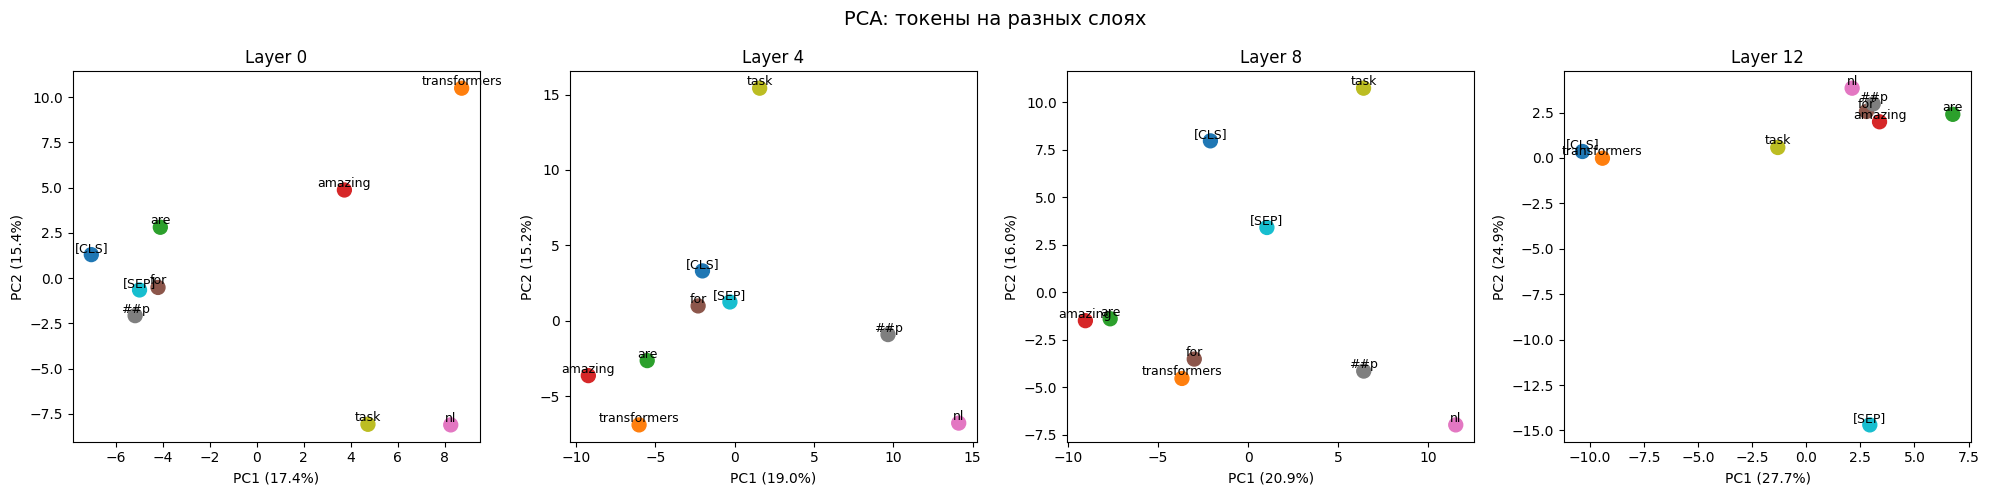

In [20]:
visualize_tokens_pca(result["hidden_states"], result["tokens"])